In [1]:
!sudo apt-get install -y xvfb
!pip install pyvirtualdisplay
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 784 kB in 1s (629 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package xvfb.
(Reading database ... 144568 files and directorie

In [0]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_atari
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [3]:
tf.compat.v1.enable_v2_behavior()

display = pyvirtualdisplay.Display(visible=0, size=(500,1100)).start()

tf.version.VERSION

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


'2.2.0-rc3'

#Hyperparameters


In [0]:
num_interations = 100000000 # @param {type:"integer"}
replay_buffer_max_length = 1000000 # @param {type:"integer"}
batch_size = 64 # @param {type:"integer"}
learning_rate = .001 # @param {type:"number"}
log_interval = 200 # @param {type:"integer"}
eval_interval = 750 # @param {type:"integer"}

In [0]:
env_name = "FishingDerby-v0" # @param {type:"string"}
env = suite_atari.load(env_name)

In [6]:
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8))

In [7]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(84, 84, 1), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255))

In [8]:
print("Observation Sped: ")
print(env.time_step_spec().observation)

Observation Sped: 
BoundedArraySpec(shape=(84, 84, 1), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [9]:
print("Action Spec: ")
print(env.action_spec())

Action Spec: 
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=17)


In [10]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [11]:
from gym import envs
print(envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [0]:
time_step = env.reset()

In [13]:
for _ in range(200):
  action = np.array(5, dtype=np.int32)
  next_time_step = env.step(action)
print('Next time step: ')
print(next_time_step)

Next time step: 
TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8))


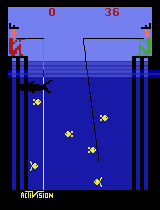

In [14]:
import PIL

PIL.Image.fromarray(env.render())

In [0]:
eval_env = tf_py_environment.TFPyEnvironment(env)

In [0]:
preprocessing_layer = tf.keras.layers.Lambda(
    lambda obs: tf.cast(obs, np.float32) / 255.)

conv_layer_params = [(32, (8,8), 4), (64, (4,4), 2),(64, (3,3), 1)]
fc_layer_params = [512]

q_net = q_network.QNetwork(
    eval_env.observation_spec(),
    env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params = conv_layer_params,
    fc_layer_params=fc_layer_params)

In [0]:
optimizer = tf.compat.v1.train.AdadeltaOptimizer(learning_rate=learning_rate)

training_step = tf.Variable(0)

update_period = 4

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=(250000) // update_period, 
    end_learning_rate=0.01)

agent = dqn_agent.DqnAgent(
    eval_env.time_step_spec(),
    eval_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=common.element_wise_huber_loss,
    gamma=0.99,
    train_step_counter=training_step,
    epsilon_greedy=lambda: epsilon_fn(training_step))

agent.initialize()

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=eval_env.batch_size,
    max_length=replay_buffer_max_length)

replay_buffer_observer = replay_buffer.add_batch

In [19]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(84, 84, 1), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(17)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [20]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [23]:
train_metrics = [
                 tf_metrics.NumberOfEpisodes(),
                 tf_metrics.EnvironmentSteps(),
                 tf_metrics.AverageReturnMetric(),
                 tf_metrics.AverageEpisodeLengthMetric()
                 ]

def metrics_log(metrics, prefix=''):
  log = ['{0} = {1}'.format(m.name, m.result().numpy()) for m in metrics]
  return '{0}\n{1}'.format(prefix, '\n'.join(log))

print(metrics_log(train_metrics))


NumberOfEpisodes = 0
EnvironmentSteps = 0
AverageReturn = 0.0
AverageEpisodeLength = 0.0


In [0]:
collect_driver = dynamic_step_driver.DynamicStepDriver(
    eval_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period)

In [0]:
class ShowProgress:
  def __init__(self, total):
    self.counter = 0
    self.total = total
  def __call__(self, trajectory):
    if not trajectory.is_boundary():
      self.counter += 1
    if self.counter % 100 == 0:
      print("\r{0}/{1}".format(self.counter, self.total), end="")

In [37]:
initial_collect_policy = random_tf_policy.RandomTFPolicy(eval_env.time_step_spec(), eval_env.action_spec())

init_driver = dynamic_step_driver.DynamicStepDriver(
    eval_env,
    initial_collect_policy, 
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000)

final_time_step, final_policy_state = init_driver.run()

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
20000/20000

In [45]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=6,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 84, 84, 1), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.uint8, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [47]:
!lscpu | grep 'Model name'
!lscpu | grep 'Core(s) per socket'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Thread(s) per core'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Core(s) per socket:  2
Socket(s):           1
Thread(s) per core:  2


In [0]:
global_step = tf.compat.v1.train.get_global_step()

In [0]:
def train_agent(n_iterations, checkpoint):
  time_step = None
  policy_state = agent.collect_policy.get_initial_state(eval_env.batch_size)
  iterator = iter(dataset)
  for iteration in range(n_iterations):
    time_step, policy_state = collect_driver.run(time_step, policy_state)
    trajectories, buff_info = next(iterator)
    train_loss = agent.train(trajectories)
    print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy(), end=""))
    if iteration % log_interval == 0:
      print(metrics_log(train_metrics))
    if iteration % 1000 == 0:
      checkpoint.save(global_step)

In [0]:
train_checkpointer = common.Checkpointer(
    ckpt_dir='/content/drive/My Drive/Data/CheckPoint',
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer)

In [59]:
train_agent(num_interations, train_checkpointer)

1245 loss:0.17777
1246 loss:0.13178
1247 loss:0.17844
1248 loss:0.14517
1249 loss:0.12235
1250 loss:0.13529
1251 loss:0.03231
1252 loss:0.20132
1253 loss:0.09377
1254 loss:0.04434
1255 loss:0.17951
1256 loss:0.07697
1257 loss:0.05427
1258 loss:0.25376
1259 loss:0.13965
1260 loss:0.24620
1261 loss:0.03107
1262 loss:0.17010
1263 loss:0.11868
1264 loss:0.05403
1265 loss:0.20658
1266 loss:0.16556
1267 loss:0.08735
1268 loss:0.10541
1269 loss:0.17666
1270 loss:0.13905
1271 loss:0.17682
1272 loss:0.18243
1273 loss:0.14870
1274 loss:0.06293
1275 loss:0.13058
1276 loss:0.09098
1277 loss:0.08603
1278 loss:0.11655
1279 loss:0.09257
1280 loss:0.17662
1281 loss:0.16191
1282 loss:0.20535
1283 loss:0.20804
1284 loss:0.14508


KeyboardInterrupt: ignored

In [57]:
train_checkpointer.initialize_or_restore()

In [0]:
def embed_mp4(filename):
  video = open(filename, 'rb').read()
  b64 = base64.b64encode(video)
  tag='''
  <video width = "640" height="480" controls>
    <cource src="data:video/mp4;base64,{0}" type="video/mp4">
  <video> '''.format(b64.decode())

  return IPython.display.HTML(tag)

In [0]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(env.render())
  return embed_mp4(filename)

In [62]:
create_policy_eval_video(agent.policy, "stage1-train-agent")